![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# Lecture 4 Support Notebook

### Table of Contents
<p>
<div class="lev1">
    <a href="#Short-Corredor-Problem">
        <span class="toc-item-num">1&nbsp;&nbsp;</span>
        Short Corredor Problem
    </a>
</div>
<div class="lev1">
    <a href="#Clifwalk-REINFORCE-with-Baseline"><span class="toc-item-num">2.&nbsp;&nbsp;</span>
        Clifwalk REINFORCE with Baseline
    </a>
</div>
<div class="lev1">
    <a href="#Clifwalk-Actor-Critic-for-Discrete-Action-Spaces"><span class="toc-item-num">3.1.&nbsp;&nbsp;</span>
        Clifwalk Actor Critic for Discrete Action Spaces
    </a>
</div>
<div class="lev1">
    <a href="#Mountain-Car-Actor-Critic-for-Continuous-Action-Spaces"><span class="toc-item-num">3.2.&nbsp;&nbsp;</span>
        Mountain Car Actor Critic for Continuous Action Spaces
    </a>
</div>

# Short Corredor Problem

ref. https://github.com/jcassiojr/Reinforcement-Learning-In-Motion/tree/master/Unit-8-The-Mountaincar
others: reinforce, discrete and continuous mountain from sutton exercices (Policy Gradient)

In [2]:
#! pip install gym

In [3]:
%matplotlib inline

import gym
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (8, 5)

from IPython.display import display, Image
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import tensorflow as tf
import collections

from scipy.stats import norm

if "../" not in sys.path:
  sys.path.append("../") 
from lib_rl.envs.cliff_walking import CliffWalkingEnv
from lib_rl import plotting

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
# Continuous case libraries
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')


/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

USE BELOW!!!
https://github.com/zyxue/sutton-barto-rl-exercises/blob/master/reinforcement/policy-gradient-methods/Example-13.1-short-corridor-with-switched-actions.ipynb

Consider the small corridor gridworld shown inset in the graph below. The reward
is 1 per step, as usual. In each of the three nonterminal states there are only
two actions, right and left. These actions have their usual consequences in the first
and third states (left causes no movement in the first state), but in the second
state they are reversed, so that right moves to the left and left moves to the right.
The problem is dicult because all the states appear identical under the function
approximation. In particular, we define x(s,right) = [1, 0]> and x(s, left) = [0, 1]>,
for all s. An action-value method with "-greedy action selection is forced to choose
between just two policies: choosing right with high probability 1  "/2 on all steps
or choosing left with the same high probability on all time steps. If " = 0.1, then
these two policies achieve a value (at the start state) of less than 44 and 82,
respectively, as shown in the graph. A method can do significantly better if it can
learn a specific probability with which to select right. The best probability is about
0.59, which achieves a value of about

<img src="../images/short-corridor-with-switched-actions.png" alt="Drawing" style="width: 300px;">

In [4]:
INIT_STATE = 0
TERMINAL_STATE = 3
# state that reverse the result of the action
REVERSE_STATE = 1
LEFT = -1
RIGHT = 1
ACTIONS = [LEFT, RIGHT]

def generate_an_episode(starting_state, greedy_action, prob_right):
    state = starting_state
    reward = 0
    while state != TERMINAL_STATE:
        if np.random.random() <= prob_right:
            act = RIGHT
        else:
            act = LEFT

        if state == REVERSE_STATE:
            state -= act
        else:
            state += act
        reward -= 1
        state = max(state, 0)
    return reward

In [5]:
epsilon = 0.1
# epsilon-greedy left
prob_right = epsilon / 2

rewards = []
for i in range(2000):
    rewards.append(generate_an_episode(INIT_STATE, RIGHT, prob_right))

In [6]:
np.mean(rewards)

-83.8885

In [7]:
epsilon = 0.1
# epsilon-greedy right
prob_right = (1 - epsilon) + epsilon / 2

rewards = []
for i in range(2000):
    rewards.append(generate_an_episode(INIT_STATE, RIGHT, prob_right))

In [8]:
np.mean(rewards)

-45.8545

Maximize
$$f(p) = p(1-p)p = p^2 - p^3$$
to obtain the best policy. Then $p = \frac{2}{3}$ (differentiate $f$ and set derivative to zero), to calculate the corresponding $\epsilon$, set
$$\frac{\epsilon}{2} + (1 - \epsilon) = \frac{2}{3}$$
It turns out $\epsilon = \frac{2}{3}$, too.
Calculate the opitmal value of the initial state may be more involved, so just simulate.

In [9]:
# probabilities of going right
probs = np.sort(np.arange(0.02, 1, 0.02).tolist() + [2/3])

avg_rewards = []
std_rewards = []
for k, p in enumerate(probs):
    print(k, end=',')
    rewards = []
    for i in range(2000):
        rewards.append(generate_an_episode(INIT_STATE, RIGHT, p))
    avg_rewards.append(np.mean(rewards))
    std_rewards.append(np.std(rewards))

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,

Text(0, 0.5, 'Value of state S')

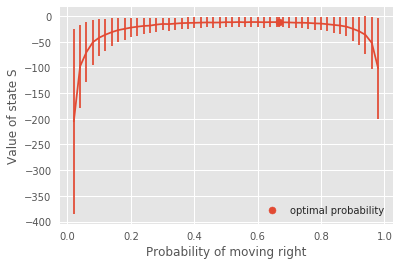

In [10]:
plt.errorbar(probs, avg_rewards, yerr=std_rewards)
idx = np.where(probs == 2/3)[0][0]
plt.scatter([probs[idx]], avg_rewards[idx], label='optimal probability')
plt.legend(loc='lower right')
plt.xlabel('Probability of moving right')
plt.ylabel('Value of state S')

In [11]:
idx

33

In [12]:
np.argmax(avg_rewards)

26

The best reward is around 2/3 because the region around it is very flat.

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Clifwalk REINFORCE with Baseline
## <TODO explanation of clifwalk environment (from assignment N)
### The Clifwalk Problem
<img src="../images/RL-lecture3-1.png" alt="Drawing" style="width: 300px;">
The Mountain Car is a classic reinforcement learning problem where the objective is to create an algorithm which learns to climb a steep hill to reach the goal marked by a flag. The car’s engine is not powerful enough to drive up the hill without a head start so the car must drive up the left hill to obtain enough momentum to scale the steeper hill to the right and reach the goal.<br/>

+ When the problem begins the car is dropped into the valley and given an initial position and velocity as a vector. **This is the car’s state**.
<img src="../images/RL-lecture3-2.png" alt="Drawing" style="width: 300px;">
+ The agent must tell the car to take one of three actions: 
<img src="../images/RL-lecture3-3.png" alt="Drawing" style="width: 200px;">
+ This action is sent to the Mountain Car environment algorithm which returns a new state (position and velocity) as well as a reward. 
+ For each step that the car does not reach the goal, located at position 0.5, the environment returns a reward of -1. 
+ We will use these rewards in our Q-Learning algorithm to solve the Mountain Car problem.

In [16]:
env = CliffWalkingEnv()

### Exploring the Environment

In [17]:
env.action_space.sample()

0

In [18]:
env.observation_space.sample()

2

In [19]:
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)

State space:  Discrete(48)
Action space:  Discrete(4)


This tells us that the state space represents a 2-dimensional box, so each state observation is a vector of 2 (float) values, and that the action space comprises three discrete actions.

By default, the three actions are represented by the integers 0, 1 and 2. However, we don’t know what values the elements of the state vector can take. This can be found using:

In [ ]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [ ]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [ ]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the first action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
    return stats

In [ ]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~2000-5000 seemed to work well for me.
    stats = reinforce(env, policy_estimator, value_estimator, 2000, discount_factor=1.0)

In [ ]:
plotting.plot_episode_stats(stats, smoothing_window=25)

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Clifwalk Actor Critic for Discrete Action Spaces

In [13]:
env = CliffWalkingEnv()

In [14]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [15]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [16]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [17]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    stats = actor_critic(env, policy_estimator, value_estimator, 300)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step 15 @ Episode 300/300 (-114.0))

In [ ]:
plotting.plot_episode_stats(stats, smoothing_window=10)

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook">
        <span class="toc-item-num">&nbsp;&nbsp;</span>
        Go to TOP
    </a>
</div>

# Mountain Car Actor Critic for Continuous Action Spaces

In [20]:
env = gym.envs.make("MountainCarContinuous-v0")

### Exploring the Environment

In [21]:
env.action_space.sample()

array([-0.36159036], dtype=float32)

In [22]:
env.observation_space.sample()

array([-0.54248476,  0.00816753], dtype=float32)

In [23]:
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)

State space:  Box(2,)
Action space:  Box(1,)


In [24]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to converte a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [25]:
def featurize_state(state):
    """
    Returns the featurized representation for a state.
    """
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0]

In [26]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            self.action = self.normal_dist._sample_n(1)
            self.action = tf.clip_by_value(self.action, env.action_space.low[0], env.action_space.high[0])

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [27]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [400], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just linear classifier
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = featurize_state(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [28]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # env.render()
            
            # Take a step
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [29]:
%time
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    stats = actor_critic(env, policy_estimator, value_estimator, 50, discount_factor=0.95)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Step 410 @ Ep

In [ ]:
plotting.plot_episode_stats(stats, smoothing_window=10)